Epoch 0, Loss = 1.010178
Epoch 50, Loss = 0.082342
Epoch 100, Loss = 0.037640
Epoch 150, Loss = 0.044292


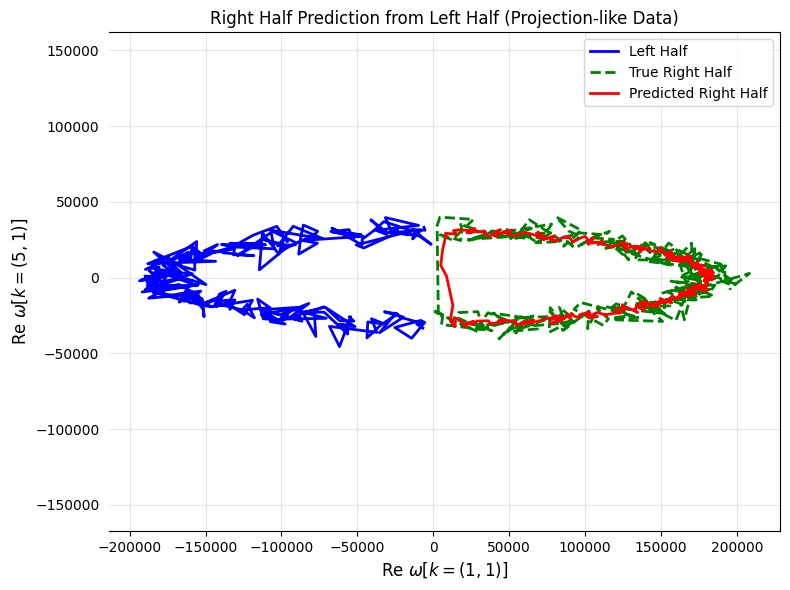

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

def generate_projection_like_data(num_loops=20, points=500):
    """Generate data mimicking projection.dat with oscillatory, noisy loops."""
    t = np.linspace(0, 2 * np.pi, points)
    data = []
    np.random.seed(42)
    for _ in range(num_loops):
        # First column: High-amplitude sinusoid (~150,000-200,000)
        x = 180000 * np.cos(t) + np.random.normal(0, 10000, points)
        # Second column: Lower-amplitude sinusoid (~10,000-40,000)
        y = 30000 * np.sin(t) + np.random.normal(0, 5000, points)
        loop = np.column_stack((x, y))
        data.append(loop)
    return np.vstack(data)

def run_elliptical_predictor():
    # 1. Data Generation - Projection-like Loops
    data = generate_projection_like_data()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 2. Split into Left/Right Halves
    LOOP_POINTS = 500
    num_loops = len(data_scaled) // LOOP_POINTS

    X_left, Y_right = [], []
    for i in range(num_loops):
        loop = data_scaled[i * LOOP_POINTS:(i + 1) * LOOP_POINTS]
        left_mask = loop[:, 0] <= 0
        right_mask = loop[:, 0] >= 0
        left_points = loop[left_mask][:LOOP_POINTS // 2]
        right_points = loop[right_mask][:LOOP_POINTS // 2]
        # Ensure exactly 250 points per half
        if len(left_points) < LOOP_POINTS // 2:
            left_points = np.pad(left_points, ((0, LOOP_POINTS // 2 - len(left_points)), (0, 0)), mode='edge')
        if len(right_points) < LOOP_POINTS // 2:
            right_points = np.pad(right_points, ((0, LOOP_POINTS // 2 - len(right_points)), (0, 0)), mode='edge')
        X_left.append(left_points)
        Y_right.append(right_points)

    # 3. Simplified Predictor Model
    class CleanPredictor(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.LSTM(2, 128, num_layers=2, batch_first=True)
            self.decoder = nn.Linear(128, LOOP_POINTS // 2 * 2)
            
        def forward(self, x):
            _, (hidden, _) = self.encoder(x)
            return self.decoder(hidden[-1]).view(-1, LOOP_POINTS // 2, 2)

    # 4. Training
    model = CleanPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    X_train = torch.FloatTensor(np.array(X_left[:int(0.85 * len(X_left))]))
    Y_train = torch.FloatTensor(np.array(Y_right[:int(0.85 * len(Y_right))]))
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

    for epoch in range(200):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss = {total_loss / len(train_loader):.6f}")

    # 5. Visualization
    def show_clean_prediction(idx=-1):
        model.eval()
        with torch.no_grad():
            left = X_left[idx]
            true_right = Y_right[idx]
            pred_right = model(torch.FloatTensor(left).unsqueeze(0)).squeeze(0).numpy()
            
            # Inverse transform
            left_orig = scaler.inverse_transform(left)
            true_right_orig = scaler.inverse_transform(true_right)
            pred_right_orig = scaler.inverse_transform(pred_right)
            
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            
            # Plot halves
            plt.plot(left_orig[:, 0], left_orig[:, 1], 'b-', linewidth=2, label='Left Half')
            plt.plot(true_right_orig[:, 0], true_right_orig[:, 1], 'g--', linewidth=2, label='True Right Half')
            plt.plot(pred_right_orig[:, 0], pred_right_orig[:, 1], 'r-', linewidth=2, label='Predicted Right Half')
            
            # Remove y-axis line but keep grid and x-axis
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')
            
            plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
            plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.axis('equal')
            plt.title("Right Half Prediction from Left Half (Projection-like Data)")
            plt.tight_layout()
            plt.show()

    show_clean_prediction()

if __name__ == "__main__":
    run_elliptical_predictor()

Epoch 0, Loss = 1.012310
Epoch 50, Loss = 0.072972
Epoch 100, Loss = 0.015272
Epoch 150, Loss = 0.015774


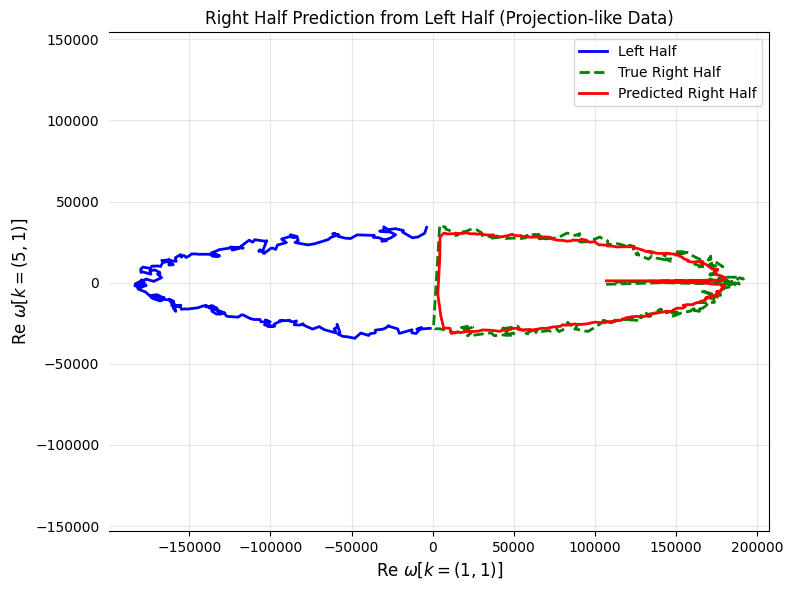

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

def generate_projection_like_data(num_loops=20, points=500):
    """Generate data mimicking projection.dat with oscillatory, noisy loops and apply smoothing."""
    t = np.linspace(0, 2 * np.pi, points)
    data = []
    np.random.seed(42)
    for _ in range(num_loops):
        # First column: High-amplitude sinusoid (~150,000-200,000)
        x = 180000 * np.cos(t) + np.random.normal(0, 10000, points)
        # Second column: Lower-amplitude sinusoid (~10,000-40,000)
        y = 30000 * np.sin(t) + np.random.normal(0, 5000, points)
        # Apply moving average smoothing with window size 5
        window_size = 5
        x_smooth = np.convolve(x, np.ones(window_size)/window_size, mode='same')
        y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='same')
        loop = np.column_stack((x_smooth, y_smooth))
        data.append(loop)
    return np.vstack(data)

def run_elliptical_predictor():
    # 1. Data Generation - Projection-like Loops
    data = generate_projection_like_data()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 2. Split into Left/Right Halves
    LOOP_POINTS = 500
    num_loops = len(data_scaled) // LOOP_POINTS

    X_left, Y_right = [], []
    for i in range(num_loops):
        loop = data_scaled[i * LOOP_POINTS:(i + 1) * LOOP_POINTS]
        left_mask = loop[:, 0] <= 0
        right_mask = loop[:, 0] >= 0
        left_points = loop[left_mask][:LOOP_POINTS // 2]
        right_points = loop[right_mask][:LOOP_POINTS // 2]
        # Ensure exactly 250 points per half
        if len(left_points) < LOOP_POINTS // 2:
            left_points = np.pad(left_points, ((0, LOOP_POINTS // 2 - len(left_points)), (0, 0)), mode='edge')
        if len(right_points) < LOOP_POINTS // 2:
            right_points = np.pad(right_points, ((0, LOOP_POINTS // 2 - len(right_points)), (0, 0)), mode='edge')
        X_left.append(left_points)
        Y_right.append(right_points)

    # 3. Simplified Predictor Model
    class CleanPredictor(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.LSTM(2, 128, num_layers=2, batch_first=True)
            self.decoder = nn.Linear(128, LOOP_POINTS // 2 * 2)
            
        def forward(self, x):
            _, (hidden, _) = self.encoder(x)
            return self.decoder(hidden[-1]).view(-1, LOOP_POINTS // 2, 2)

    # 4. Training
    model = CleanPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    X_train = torch.FloatTensor(np.array(X_left[:int(0.85 * len(X_left))]))
    Y_train = torch.FloatTensor(np.array(Y_right[:int(0.85 * len(Y_right))]))
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

    for epoch in range(200):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss = {total_loss / len(train_loader):.6f}")

    # 5. Visualization
    def show_clean_prediction(idx=-1):
        model.eval()
        with torch.no_grad():
            left = X_left[idx]
            true_right = Y_right[idx]
            pred_right = model(torch.FloatTensor(left).unsqueeze(0)).squeeze(0).numpy()
            
            # Inverse transform
            left_orig = scaler.inverse_transform(left)
            true_right_orig = scaler.inverse_transform(true_right)
            pred_right_orig = scaler.inverse_transform(pred_right)
            
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            
            # Plot halves
            plt.plot(left_orig[:, 0], left_orig[:, 1], 'b-', linewidth=2, label='Left Half')
            plt.plot(true_right_orig[:, 0], true_right_orig[:, 1], 'g--', linewidth=2, label='True Right Half')
            plt.plot(pred_right_orig[:, 0], pred_right_orig[:, 1], 'r-', linewidth=2, label='Predicted Right Half')
            
            # Remove y-axis line but keep grid and x-axis
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')
            
            plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
            plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.axis('equal')
            plt.title("Right Half Prediction from Left Half (Projection-like Data)")
            plt.tight_layout()
            plt.show()

    show_clean_prediction()

if __name__ == "__main__":
    run_elliptical_predictor()

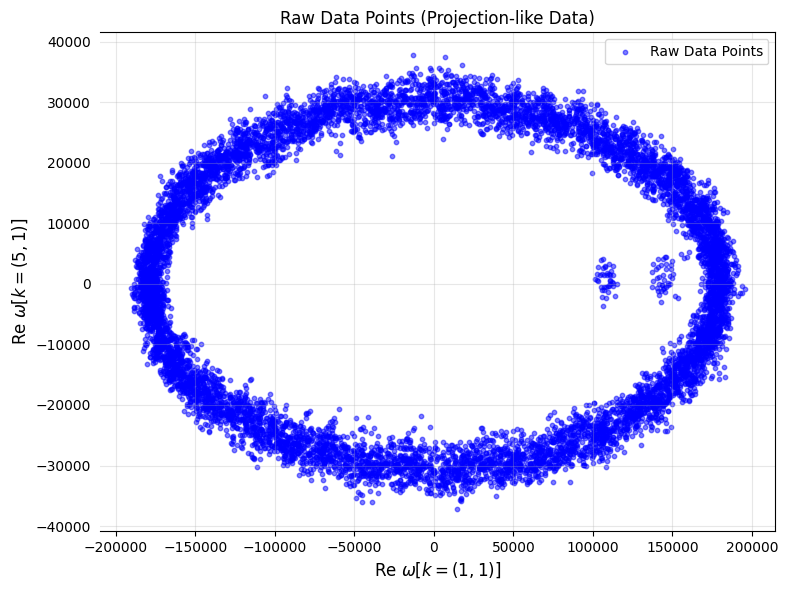

Epoch 0, Loss = 1.000315
Epoch 50, Loss = 0.072425
Epoch 100, Loss = 0.032356
Epoch 150, Loss = 0.033433


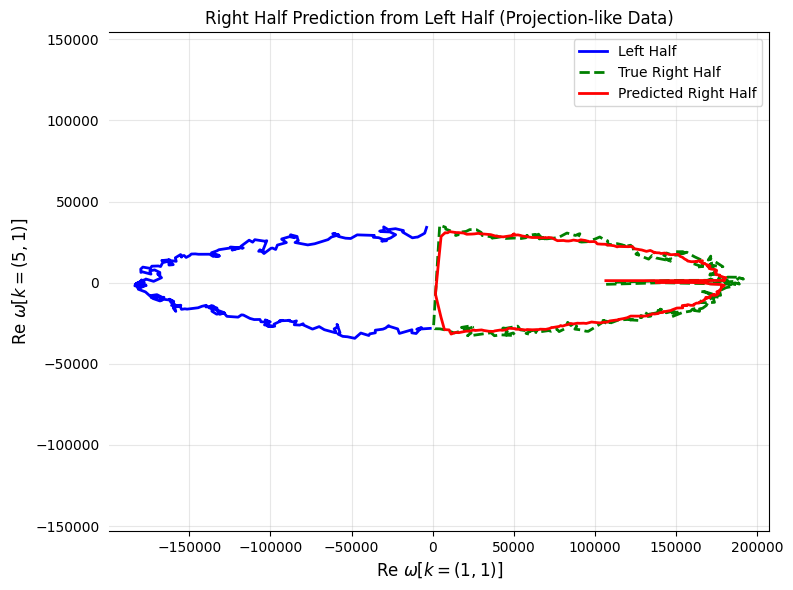

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

def generate_projection_like_data(num_loops=20, points=500):
    """Generate data mimicking projection.dat with oscillatory, noisy loops and apply smoothing."""
    t = np.linspace(0, 2 * np.pi, points)
    data = []
    np.random.seed(42)
    for _ in range(num_loops):
        # First column: High-amplitude sinusoid (~150,000-200,000)
        x = 180000 * np.cos(t) + np.random.normal(0, 10000, points)
        # Second column: Lower-amplitude sinusoid (~10,000-40,000)
        y = 30000 * np.sin(t) + np.random.normal(0, 5000, points)
        # Apply moving average smoothing with window size 5
        window_size = 5
        x_smooth = np.convolve(x, np.ones(window_size)/window_size, mode='same')
        y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='same')
        loop = np.column_stack((x_smooth, y_smooth))
        data.append(loop)
    return np.vstack(data)

def plot_raw_data_points(data):
    """Plot the raw data points generated."""
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot all data points
    plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, s=10, label='Raw Data Points')
    
    # Remove y-axis line but keep grid and x-axis
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    
    plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
    plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title("Raw Data Points (Projection-like Data)")
    plt.tight_layout()
    plt.show()

def run_elliptical_predictor():
    # 1. Data Generation - Projection-like Loops
    data = generate_projection_like_data()
    plot_raw_data_points(data)  # Added to show raw data points
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # 2. Split into Left/Right Halves
    LOOP_POINTS = 500
    num_loops = len(data_scaled) // LOOP_POINTS

    X_left, Y_right = [], []
    for i in range(num_loops):
        loop = data_scaled[i * LOOP_POINTS:(i + 1) * LOOP_POINTS]
        left_mask = loop[:, 0] <= 0
        right_mask = loop[:, 0] >= 0
        left_points = loop[left_mask][:LOOP_POINTS // 2]
        right_points = loop[right_mask][:LOOP_POINTS // 2]
        # Ensure exactly 250 points per half
        if len(left_points) < LOOP_POINTS // 2:
            left_points = np.pad(left_points, ((0, LOOP_POINTS // 2 - len(left_points)), (0, 0)), mode='edge')
        if len(right_points) < LOOP_POINTS // 2:
            right_points = np.pad(right_points, ((0, LOOP_POINTS // 2 - len(right_points)), (0, 0)), mode='edge')
        X_left.append(left_points)
        Y_right.append(right_points)

    # 3. Simplified Predictor Model
    class CleanPredictor(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.LSTM(2, 128, num_layers=2, batch_first=True)
            self.decoder = nn.Linear(128, LOOP_POINTS // 2 * 2)
            
        def forward(self, x):
            _, (hidden, _) = self.encoder(x)
            return self.decoder(hidden[-1]).view(-1, LOOP_POINTS // 2, 2)

    # 4. Training
    model = CleanPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    X_train = torch.FloatTensor(np.array(X_left[:int(0.85 * len(X_left))]))
    Y_train = torch.FloatTensor(np.array(Y_right[:int(0.85 * len(Y_right))]))
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=16, shuffle=True)

    for epoch in range(200):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss = {total_loss / len(train_loader):.6f}")

    # 5. Visualization
    def show_clean_prediction(idx=-1):
        model.eval()
        with torch.no_grad():
            left = X_left[idx]
            true_right = Y_right[idx]
            pred_right = model(torch.FloatTensor(left).unsqueeze(0)).squeeze(0).numpy()
            
            # Inverse transform
            left_orig = scaler.inverse_transform(left)
            true_right_orig = scaler.inverse_transform(true_right)
            pred_right_orig = scaler.inverse_transform(pred_right)
            
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            
            # Plot halves
            plt.plot(left_orig[:, 0], left_orig[:, 1], 'b-', linewidth=2, label='Left Half')
            plt.plot(true_right_orig[:, 0], true_right_orig[:, 1], 'g--', linewidth=2, label='True Right Half')
            plt.plot(pred_right_orig[:, 0], pred_right_orig[:, 1], 'r-', linewidth=2, label='Predicted Right Half')
            
            # Remove y-axis line but keep grid and x-axis
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')
            
            plt.xlabel(r'Re $\omega[k=(1,1)]$', fontsize=12)
            plt.ylabel(r'Re $\omega[k=(5,1)]$', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.axis('equal')
            plt.title("Right Half Prediction from Left Half (Projection-like Data)")
            plt.tight_layout()
            plt.show()

    show_clean_prediction()

if __name__ == "__main__":
    run_elliptical_predictor()